In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install gdown
!pip install gdown

# Download the file from Google Drive
!gdown --id 1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke

# Extract the tar file
import tarfile

# Open the tar file
with tarfile.open('selected_images.tar', 'r') as tar:
    tar.extractall()  # Extract to the current working directory

# List the extracted files to verify
import os

# Check the contents of the current directory
print(os.listdir())


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke
From (redirected): https://drive.google.com/uc?id=1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke&confirm=t&uuid=566090bc-ee4c-4116-98ee-806412931af1
To: /kaggle/working/selected_images.tar
100%|████████████████████████████████████████| 620M/620M [00:13<00:00, 47.3MB/s]
['selected_images', '.virtual_documents', 'selected_images.tar']


In [2]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BeitForImageClassification, BeitFeatureExtractor
import torch.nn as nn
import torch.optim as optim

In [13]:
# Function to apply dull razor effect
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return img, dst

In [14]:
# Custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        
        # Apply hair removal
        _, processed_img = apply_dullrazor(img_path)
        pil_img = Image.fromarray(processed_img)

        if self.transform:
            pil_img = self.transform(pil_img)

        return pil_img, label

In [15]:
# Load BEiT model and feature extractor
feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")
model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

/opt/conda/lib/python3.10/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [16]:
# Prepare your dataset path
dataset_path = "/kaggle/working/selected_images"  # Update with your actual path

In [17]:
# Prepare data
img_paths = []
labels = []
class_names = os.listdir(dataset_path)

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_idx)  # Assign numerical label

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(img_paths, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
# Transformations
transform = transforms.Compose([
    feature_extractor,
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
])

# Create datasets
train_dataset = SkinCancerDataset(X_train, y_train, transform)
val_dataset = SkinCancerDataset(X_val, y_val, transform)
test_dataset = SkinCancerDataset(X_test, y_test, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): BeitForImageClassification(
    (beit): BeitModel(
      (embeddings): BeitEmbeddings(
        (patch_embeddings): BeitPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): BeitEncoder(
        (layer): ModuleList(
          (0): BeitLayer(
            (attention): BeitAttention(
              (attention): BeitSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=False)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (relative_position_bias): BeitRelativePositionBias()
              )
              (output): BeitSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dr

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training the model
num_epochs = 30
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, val_predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / val_total)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

TypeError: Unexpected type <class 'transformers.image_processing_base.BatchFeature'>

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

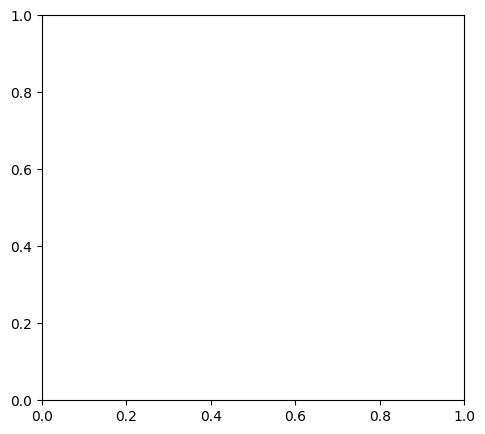

In [21]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/30], Train Loss: 2.4894, Train Acc: 0.2691, Val Loss: 1.5934, Val Acc: 0.4323
Epoch [2/30], Train Loss: 1.3772, Train Acc: 0.4945, Val Loss: 1.3987, Val Acc: 0.5052
Epoch [3/30], Train Loss: 1.0688, Train Acc: 0.6039, Val Loss: 1.1611, Val Acc: 0.5573
Epoch [4/30], Train Loss: 0.9122, Train Acc: 0.6775, Val Loss: 1.1527, Val Acc: 0.6042
Epoch [5/30], Train Loss: 0.7449, Train Acc: 0.7336, Val Loss: 1.0235, Val Acc: 0.6354
Epoch [6/30], Train Loss: 0.5951, Train Acc: 0.7870, Val Loss: 1.1034, Val Acc: 0.6354
Epoch [8/30], Train Loss: 0.3071, Train Acc: 0.8971, Val Loss: 1.1508, Val Acc: 0.5990
Epoch [9/30], Train Loss: 0.2315, Train Acc: 0.9231, Val Loss: 1.6045, Val Acc: 0.5990
Epoch [10/30], Train Loss: 0.2610, Train Acc: 0.9121, Val Loss: 1.3183, Val Acc: 0.6406
Epoch [11/30], Train Loss: 0.1616, Train Acc: 0.9537, Val Loss: 1.4726, Val Acc: 0.6094
Epoch [12/30], Train Loss: 0.1119, Train Acc: 0.9700, Val Loss: 1.4365, Val Acc: 0.6667
Epoch [13/30], Train Loss: 0.0897, Train

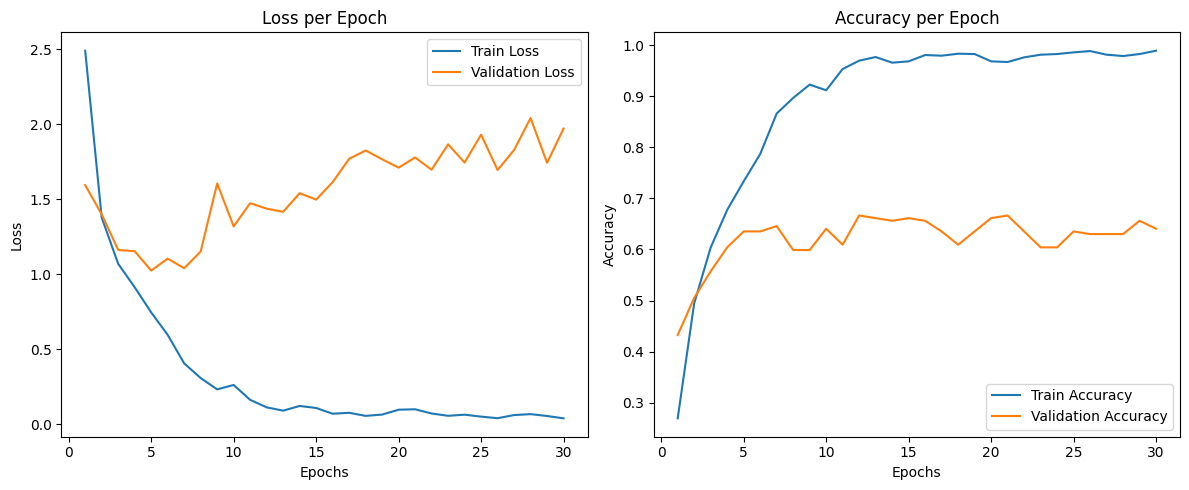

In [24]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BeitForImageClassification, BeitFeatureExtractor
import torch.nn as nn
import torch.optim as optim

# Function to apply dull razor effect
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return img, dst

# Custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        
        # Apply hair removal
        _, processed_img = apply_dullrazor(img_path)
        pil_img = Image.fromarray(processed_img)

        if self.transform:
            pil_img = self.transform(pil_img)

        return pil_img, label

# Load BEiT model and feature extractor
model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

# Prepare your dataset path
dataset_path = "/kaggle/working/selected_images"  # Update with your actual path

# Prepare data
img_paths = []
labels = []
class_names = os.listdir(dataset_path)

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_paths.append(os.path.join(class_folder, img_name))
            labels.append(class_idx)  # Assign numerical label

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(img_paths, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Transformations
transform = transforms.Compose([
    transforms.Resize((244, 244)),  # Resize to 244x244
    transforms.ToTensor(),
])

# Create datasets
train_dataset = SkinCancerDataset(X_train, y_train, transform)
val_dataset = SkinCancerDataset(X_val, y_val, transform)
test_dataset = SkinCancerDataset(X_test, y_test, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training the model
num_epochs = 30
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, val_predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / val_total)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# Save the model's state_dict (weights only)
torch.save(model.state_dict(), "skin_cancer_classification_BeIT_30epoch_base.pth")
